In [1]:
import xarray as xr
import numpy as np
import cmocean as cm
import os
import pandas as pd
from matplotlib import cm as cmap
%matplotlib inline
import pylab as plt

In [2]:
from dask.distributed import Client

In [3]:
import dask.dataframe as dd

In [4]:
c=Client()
c

Client Scheduler: tcp://127.0.0.1:40913 Dashboard: /proxy/8787/status,Cluster Workers: 6 Cores: 24 Memory: 103.08 GB


In [5]:
data=pd.read_csv('/g/data/v45/jm5970/AVISO_dataframe/trackeddy_V1.0_global_eddies.csv')
data['time']=pd.to_datetime(data['time'])

In [6]:
diameter_data =  data[['area_eddy']].copy()
diameter_data['eddy_amplitude'] = abs(data['eddy_amplitude'])
diameter_data['time'] = data['time']
diameter_data['maxima_loc_y'] = data['maxima_loc_y']
diameter_data['diameter'] = ( np.sqrt(data[['area_eddy']]/(np.pi))*2 )/ 1000

In [7]:
diameter_data['binned_area'] = pd.cut(diameter_data['diameter'], np.linspace(0,4e2,50))

In [8]:
diameter_data_hist = diameter_data.groupby(diameter_data['binned_area']).count()

In [9]:
diameter_data_hist = diameter_data_hist.reset_index()

In [10]:
diameter_data_hist['binned_area']=np.linspace(0,4e2,49)

In [11]:
diameter_data_hist = diameter_data_hist.set_index('binned_area')

In [17]:
ts_large_diameter_nh_ungroup = diameter_data.where(diameter_data['maxima_loc_y'] >10).where(diameter_data['maxima_loc_y'] < 60).where(diameter_data['diameter']>120).dropna()
ts_small_diameter_nh_ungroup = diameter_data.where(diameter_data['maxima_loc_y'] >10).where(diameter_data['maxima_loc_y'] < 60).where(diameter_data['diameter']<120).dropna()

In [18]:
ts_large_diameter_nh = ts_large_diameter_nh_ungroup.groupby("time").mean()
ts_small_diameter_nh = ts_small_diameter_nh_ungroup.groupby("time").mean()

In [19]:
ts_large_diameter_sh_ungroup = diameter_data.where(diameter_data['maxima_loc_y'] < -10).where(diameter_data['maxima_loc_y'] > -60).where(diameter_data['diameter']>120).dropna()
ts_small_diameter_sh_ungroup = diameter_data.where(diameter_data['maxima_loc_y'] < -10).where(diameter_data['maxima_loc_y'] > -60).where(diameter_data['diameter']<120).dropna()

In [20]:
ts_large_diameter_sh = ts_large_diameter_sh_ungroup.groupby("time").mean()
ts_small_diameter_sh = ts_small_diameter_sh_ungroup.groupby("time").mean()

### Sample randomly

In [21]:
number_large_eddies = len(ts_large_diameter_nh_ungroup.unstack())

In [100]:
percentage_to_extract = int(number_large_eddies*0.01)

In [101]:
# ts_large_diameter_nh_sampled = ts_large_diameter_nh_ungroup.sample(percentage_to_extract)
# ts_small_diameter_nh_sampled = ts_small_diameter_nh_ungroup.sample(percentage_to_extract)

In [102]:
# ts_large_diameter_sh_sampled = ts_large_diameter_sh_ungroup.sample(percentage_to_extract)
# ts_small_diameter_sh_sampled = ts_small_diameter_sh_ungroup.sample(percentage_to_extract)

In [103]:
# scale_sampes = {'nh':{'large':[],'small':[]}, 'sh':{'large':[],'small':[]}}
def compute_sample(data,n,n_samples=100):
    sample_store = {ii:None for ii in range(n_samples)}
    for sample in range(n_samples):
        sampled_data = data.sample(n)
        ts_sampled_data = sampled_data.groupby("time").mean()
        ts_sampled_data['month'] = ts_sampled_data.index.month
        season_sampled_data = ts_sampled_data.groupby(['month']).mean()
        season_sampled_data.loc[0]= season_sampled_data.loc[12]
        season_sampled_data.loc[13]= season_sampled_data.loc[1]
        season_sampled_data = season_sampled_data.sort_index()
        sample_store[sample] = season_sampled_data
    return pd.concat(sample_store)

In [104]:
ts_large_diameter_nh['month'] = ts_large_diameter_nh.index.month
ts_small_diameter_nh['month'] = ts_small_diameter_nh.index.month
ts_large_diameter_sh['month'] = ts_large_diameter_sh.index.month
ts_small_diameter_sh['month'] = ts_small_diameter_sh.index.month

In [105]:
ts_large_diameter_nh_season = ts_large_diameter_nh.groupby(['month']).mean()
ts_large_diameter_nh_season.loc[0]= ts_large_diameter_nh_season.loc[12]
ts_large_diameter_nh_season.loc[13]= ts_large_diameter_nh_season.loc[1]
ts_large_diameter_nh_season = ts_large_diameter_nh_season.sort_index()

In [106]:
ts_small_diameter_nh_season = ts_small_diameter_nh.groupby(['month']).mean()
ts_small_diameter_nh_season.loc[0]= ts_small_diameter_nh_season.loc[12]
ts_small_diameter_nh_season.loc[13]= ts_small_diameter_nh_season.loc[1]
ts_small_diameter_nh_season = ts_small_diameter_nh_season.sort_index()

In [107]:
ts_large_diameter_sh_season = ts_large_diameter_sh.groupby(['month']).mean()
ts_large_diameter_sh_season.loc[0]= ts_large_diameter_sh_season.loc[12]
ts_large_diameter_sh_season.loc[13]= ts_large_diameter_sh_season.loc[1]
ts_large_diameter_sh_season = ts_large_diameter_sh_season.sort_index()

In [108]:
ts_small_diameter_sh_season = ts_small_diameter_sh.groupby(['month']).mean()
ts_small_diameter_sh_season.loc[0]= ts_small_diameter_sh_season.loc[12]
ts_small_diameter_sh_season.loc[13]= ts_small_diameter_sh_season.loc[1]
ts_small_diameter_sh_season = ts_small_diameter_sh_season.sort_index()

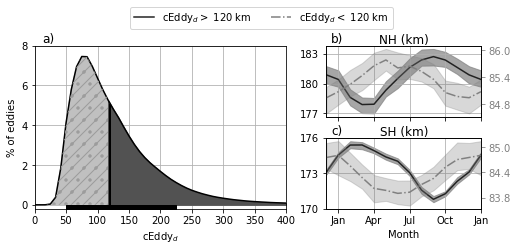

In [109]:
fig=plt.figure(figsize=(8,3))
plt.rcParams.update({'hatch.color': '#9C9C9C'})

#################################################################

grid = plt.GridSpec(2, 5, wspace=0.7, hspace=0.3)

axs1 = fig.add_subplot(grid[0:3, 0:3])

percent_eddies = ((diameter_data_hist['area_eddy']/diameter_data_hist['area_eddy'].sum())*100)
axs1.plot(percent_eddies.index,percent_eddies,color='k')


q_05 = diameter_data_hist['area_eddy'].quantile(q=0.15)/1000
q_95 = diameter_data_hist['area_eddy'].quantile(q=0.452)/1000

fill_x = diameter_data_hist['area_eddy'].loc[slice(0,120)].index
axs1.fill_between(fill_x,percent_eddies.loc[slice(0,120)],color='#C0C0C0',zorder=2,hatch='/.')
axs1.fill_between(fill_x,percent_eddies.loc[slice(0,120)],alpha=0,zorder=3,hatch='//.')
fill_x = diameter_data_hist['area_eddy'].loc[slice(110,400)].index
axs1.fill_between(fill_x,percent_eddies.loc[slice(110,400)],color='#525252',zorder=2)
axs1.plot([120,120],[0,5],color='k',linewidth=2)

fill_x = diameter_data_hist['area_eddy'].loc[slice(q_05,q_95)].index
axs1.fill_between(fill_x,list([-0.2])*22,color='k',zorder=4)

axs1.set_xlabel(r'$\mathrm{cEddy}_d$ ') 
axs1.set_ylabel(r'% of eddies') 
axs1.grid(zorder=-1)
axs1.set_xlim((0,400))
axs1.set_ylim((-0.2,8))

axs2 = fig.add_subplot(grid[0, 3:5])
ts_large_diameter_nh_season['diameter'].plot(ax=axs2,linestyle='-',color='#222222')
# Display error 
ts_large_diameter_nh_sampled = compute_sample(ts_large_diameter_nh_ungroup,percentage_to_extract)
max_range = ts_large_diameter_nh_sampled['diameter'].unstack().max()
min_range = ts_large_diameter_nh_sampled['diameter'].unstack().min()
plt.fill_between(min_range.index,min_range.values,max_range.values,color='gray',alpha=0.7)
axs2.set_yticks((177,180,183))

# axs2.tick_params(axis='y', colors='#525252')

axs2_t = axs2.twinx()
ts_small_diameter_nh_season['diameter'].plot(ax=axs2_t,linestyle='-.',color='gray')
# Display error 
ts_small_diameter_nh_sampled = compute_sample(ts_small_diameter_nh_ungroup,percentage_to_extract)
max_range = ts_small_diameter_nh_sampled['diameter'].unstack().max()
min_range = ts_small_diameter_nh_sampled['diameter'].unstack().min()
plt.fill_between(min_range.index,min_range.values,max_range.values,color='gray',alpha=0.3)
axs2_t.set_yticks((84.8,85.4,86))

axs2.grid()
axs2.set_xticks(np.arange(1,14,3))
axs2.set_xlim((0,13))
axs2.set_xticklabels([])
axs2.set_xlabel('')
axs2.set_title("NH (km)",y=0.95)
axs2_t.tick_params(axis='y', colors='gray')

axs3 = fig.add_subplot(grid[1, 3:5])
ts_large_diameter_sh_season['diameter'].plot(ax=axs3,linestyle='-',color='#222222')
# Display error 
ts_large_diameter_nh_sampled = compute_sample(ts_large_diameter_sh_ungroup,percentage_to_extract)
max_range = ts_large_diameter_sh_sampled['diameter'].unstack().max()
min_range = ts_large_diameter_sh_sampled['diameter'].unstack().min()
plt.fill_between(min_range.index,min_range.values,max_range.values,color='gray',alpha=0.7)
axs3.set_yticks((170,173,176))
# axs3.tick_params(axis='y', colors='#525252')

axs3_t = axs3.twinx()
ts_small_diameter_sh_season['diameter'].plot(ax=axs3_t,linestyle='-.',color='gray')
# Display error 
ts_small_diameter_sh_sampled = compute_sample(ts_small_diameter_sh_ungroup,percentage_to_extract)
max_range = ts_small_diameter_sh_sampled['diameter'].unstack().max()
min_range = ts_small_diameter_sh_sampled['diameter'].unstack().min()
plt.fill_between(min_range.index,min_range.values,max_range.values,color='gray',alpha=0.3)
axs3_t.set_yticks((83.8,84.4,85))

axs3.set_title("SH (km)",y=0.95)
axs3_t.tick_params(axis='y', colors='gray')

axs3.grid()
axs3.set_xticks(np.arange(1,14,3))
axs3.set_xlim((0,13))
axs3.set_xticklabels(['Jan','Apr','Jul','Oct','Jan']);

axs1.text(0.03,1.02,r'a)',fontsize=12,transform=axs1.transAxes)
axs2.text(0.03,1.05,r'b)',fontsize=12,transform=axs2.transAxes)
axs3.text(0.03,1.05,r'c)',fontsize=12,transform=axs3.transAxes)

axs3.set_xlabel('Month')

axs1.plot([0,0],[0,0],linestyle='-',color='#222222', label="$\mathrm{cEddy}_d >$ 120 km")
axs1.plot([0,0],[0,0],linestyle='-.',color='gray', label="$\mathrm{cEddy}_d <$ 120 km")
axs1.legend(loc='upper center', bbox_to_anchor=(0.9, 1.27), ncol=2)

plt.savefig('eddy_diameter_seasonal.pdf',dpi=300,bbox_inches='tight')

In [110]:
percentage_to_extract

345885

In [111]:
number_large_eddies

34588566

In [76]:
np.arange(1,14,3)

array([ 1,  4,  7, 10, 13])

In [1]:
!pwd

/g/data/v45/jm5970/scripts_papers/paper_transient_climatology


In [60]:
np.arange(0,14,4)
['Jan','Apr','July','Oct','Jan']

['Dec']

In [19]:
percent_eddies.loc[125.00000000000001]

4.812123287609869

In [53]:
ts_small_diameter_sh_season

,area_eddy,eddy_amplitude,maxima_loc_y,diameter
month,,,,
-1,5.942562e+09,0.094105,-41.300143,84.753255
1,5.950813e+09,0.095249,-41.661998,84.804117
2,5.918469e+09,0.095053,-41.812244,84.553964
3,5.880437e+09,0.094430,-41.828953,84.278516
4,5.848561e+09,0.094164,-41.762444,84.022809
5,5.841883e+09,0.094390,-41.632666,83.975214
6,5.831320e+09,0.093228,-41.391988,83.905151
7,5.834451e+09,0.092009,-41.076604,83.932196
8,5.856789e+09,0.091260,-40.717018,84.114559
